In [1]:
from datasets import load_from_disk

e:\Question Answering\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
babi_dataset = load_from_disk('E:/Question Answering/data/')

In [3]:
babi_dataset['train'][0]

{'story': {'answer': ['', '', 'office'],
  'id': ['1', '2', '3'],
  'supporting_ids': [[], [], ['1']],
  'text': ['The office is north of the kitchen.',
   'The garden is south of the kitchen.',
   'What is north of the kitchen?'],
  'type': [0, 0, 1]}}

### Add dữ liệu story.type của babi_dataset vào trong Set

In [4]:
type_set = set()
for story in babi_dataset['train']:
    if str(story['story']['type'] )not in type_set:
        type_set.add(str(story['story']['type'] ))

In [5]:
type_set

{'[0, 0, 1]'}

### Chuyển đổi format của babi_dataset từ {story : {key1 : value, key1 : value}} về {story.key : value}

In [6]:
flattened_babi = babi_dataset.flatten()

In [7]:
flattened_babi

DatasetDict({
    train: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
})

In [8]:
next(iter(flattened_babi['train']))

{'story.answer': ['', '', 'office'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The office is north of the kitchen.',
  'The garden is south of the kitchen.',
  'What is north of the kitchen?'],
 'story.type': [0, 0, 1]}

In [9]:
def get_question_and_facts(story):
    dic = {}
    dic['question'] = story['story.text'][2]
    dic['sentences'] = ' '.join([story['story.text'][0], story['story.text'][1]])
    dic['answer'] = story['story.answer'][2]
    return dic

In [10]:
processed = flattened_babi.map(get_question_and_facts)

### Train và Test có khá Same Distribute

In [11]:
processed['train'][2]

{'story.answer': ['', '', 'bedroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['2']],
 'story.text': ['The garden is north of the office.',
  'The bedroom is north of the garden.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1],
 'question': 'What is north of the garden?',
 'sentences': 'The garden is north of the office. The bedroom is north of the garden.',
 'answer': 'bedroom'}

In [12]:
processed['test'][2]

{'story.answer': ['', '', 'bathroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The bathroom is north of the garden.',
  'The hallway is north of the bathroom.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1],
 'question': 'What is north of the garden?',
 'sentences': 'The bathroom is north of the garden. The hallway is north of the bathroom.',
 'answer': 'bathroom'}

### Tìm vị trí đầu tiên của Answer trong Sentences

In [13]:
def get_start_end_idx(story):
    str_idx = story['sentences'].find(story['answer'])
    end_idx = str_idx + len(story['answer'])
    return {'str_idx':str_idx,
          'end_idx': end_idx}

In [14]:
get_start_end_idx(processed['train'][2])

{'str_idx': 39, 'end_idx': 46}

In [15]:
processed = processed.map(get_start_end_idx)

In [16]:
num = 187
print(processed['test'][num])
start_idx = processed['test'][num]['str_idx']
end_idx = processed['test'][num]['end_idx']
print('answer:', processed['test'][num]['sentences'][start_idx:end_idx])

{'story.answer': ['', '', 'garden'], 'story.id': ['1', '2', '3'], 'story.supporting_ids': [[], [], ['2']], 'story.text': ['The hallway is south of the garden.', 'The garden is south of the bedroom.', 'What is south of the bedroom?'], 'story.type': [0, 0, 1], 'question': 'What is south of the bedroom?', 'sentences': 'The hallway is south of the garden. The garden is south of the bedroom.', 'answer': 'garden', 'str_idx': 28, 'end_idx': 34}
answer: garden


In [71]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('E:/Question Answering/tokenizer')

In [18]:
tokenizer.model_max_length

512

### Chèn padding và loại bỏ ký tự thừa nếu length khác 512

In [72]:
def tokenize_align(example):
    encoding = tokenizer(example['sentences'], example['question'], truncation=True, padding=True, max_length=tokenizer.model_max_length)
    start_positions = encoding.char_to_token(example['str_idx'])
    end_positions = encoding.char_to_token(example['end_idx']-1)
    if start_positions is None:
        start_positions = tokenizer.model_max_length
    if end_positions is None:
        end_positions = tokenizer.model_max_length
    return {'input_ids': encoding['input_ids'],
          'attention_mask': encoding['attention_mask'],
          'start_positions': start_positions,
          'end_positions': end_positions}

In [73]:
qa_dataset = processed.map(tokenize_align)

In [74]:
qa_dataset = qa_dataset.remove_columns(['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'])

### input_ids : Các Từ trong question và sentences convert sang one-hot

### 101 là bắt đầu câu sentences, 102 là bắt đầu câu question, 1012 là dấu '.' , 1029 là dấu '?'

### attention_mask chú ý đầu vào nên bỏ qua ví dụ như padding thừa sẽ ký hiệu là 0 

### start_positions và end_positions ví trí answer trong sentences -> Hình như vị trí Ouptut

In [75]:
qa_dataset['train'][15]

{'question': 'What is the bedroom east of?',
 'sentences': 'The bedroom is west of the kitchen. The office is west of the bedroom.',
 'answer': 'office',
 'str_idx': 40,
 'end_idx': 46,
 'input_ids': [101,
  1996,
  5010,
  2003,
  2225,
  1997,
  1996,
  3829,
  1012,
  1996,
  2436,
  2003,
  2225,
  1997,
  1996,
  5010,
  1012,
  102,
  2054,
  2003,
  1996,
  5010,
  2264,
  1997,
  1029,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'start_positions': 10,
 'end_positions': 10}

## Train 

In [76]:
train_ds = qa_dataset['train']
test_ds = qa_dataset['test']

In [24]:
from transformers import DistilBertConfig, TrainingArguments, Trainer, DistilBertForQuestionAnswering, TFDistilBertForQuestionAnswering

In [25]:
model = TFDistilBertForQuestionAnswering.from_pretrained("E:/Question Answering/model/", return_dict=False)

All model checkpoint layers were used when initializing TFDistilBertForQuestionAnswering.

All the layers of TFDistilBertForQuestionAnswering were initialized from the model checkpoint at E:/Question Answering/model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


In [26]:
model.summary()

Model: "tf_distil_bert_for_question_answering"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  65190912  
 inLayer)                                                        
                                                                 
 qa_outputs (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 65192450 (248.69 MB)
Trainable params: 65192450 (248.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
import tensorflow as tf

columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']

train_ds.set_format(type='tf', columns=columns_to_return)
# Input
train_features = {x: train_ds[x] for x in ['input_ids', 'attention_mask']}
# Output
train_labels = {"start_positions": tf.reshape(train_ds['start_positions'], shape=[-1,1]),
                'end_positions': tf.reshape(train_ds['end_positions'], shape=[-1,1])}

# Chia dữ liệu thành các batch nhỏ
train_tfdataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(8)

In [28]:
train_features['input_ids']

<tf.Tensor: shape=(1000, 26), dtype=int64, numpy=
array([[ 101, 1996, 2436, ..., 3829, 1029,  102],
       [ 101, 1996, 3829, ..., 1997, 1029,  102],
       [ 101, 1996, 3871, ..., 3871, 1029,  102],
       ...,
       [ 101, 1996, 6797, ..., 5010, 1029,  102],
       [ 101, 1996, 6797, ..., 5723, 1029,  102],
       [ 101, 1996, 3829, ..., 1997, 1029,  102]], dtype=int64)>

In [29]:
train_labels['start_positions']

<tf.Tensor: shape=(1000, 1), dtype=int64, numpy=
array([[ 2],
       [ 2],
       [10],
       [ 2],
       [10],
       [ 2],
       [ 2],
       [10],
       [ 2],
       [10],
       [ 2],
       [ 2],
       [10],
       [ 7],
       [ 2],
       [10],
       [ 2],
       [ 7],
       [10],
       [ 2],
       [ 2],
       [10],
       [ 2],
       [ 2],
       [ 2],
       [ 7],
       [ 2],
       [10],
       [ 2],
       [ 2],
       [ 7],
       [ 2],
       [10],
       [ 2],
       [ 2],
       [ 2],
       [10],
       [ 7],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [10],
       [ 2],
       [10],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [10],
       [ 2],
       [ 2],
       [10],
       [ 7],
       [10],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 7],
       [ 2],
       [ 2],
       [ 7],
       [ 2],
       [ 2],
       [ 7],
       [10],
       [ 7],
       [ 7],
       [ 2],
       [10],
       [10],
       [ 2],
  

In [30]:
max_start_position = tf.reduce_max(train_labels['start_positions'])
max_end_position = tf.reduce_max(train_labels['end_positions'])

print("Max start position: ", max_start_position.numpy())
print("Max end position: ", max_end_position.numpy())

Max start position:  10
Max end position:  10


In [31]:
train_ds

Dataset({
    features: ['question', 'sentences', 'answer', 'str_idx', 'end_idx', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 1000
})

### ERR : Argument name must be a string and cannot contain character /. Received: name=tf_distil_bert_for_question_answering/distilbert/embeddings/word_embeddings/weight_0_momentum

In [32]:
for weight in model.weights:
    weight._handle_name = weight.name.replace('/', '_')

### Model Many to Many

### Model Input (1, 26) Output (1, 1) -> Cho 1 chuỗi sequence -> output lấy vị trí max hay là vị trí câu trả lời  

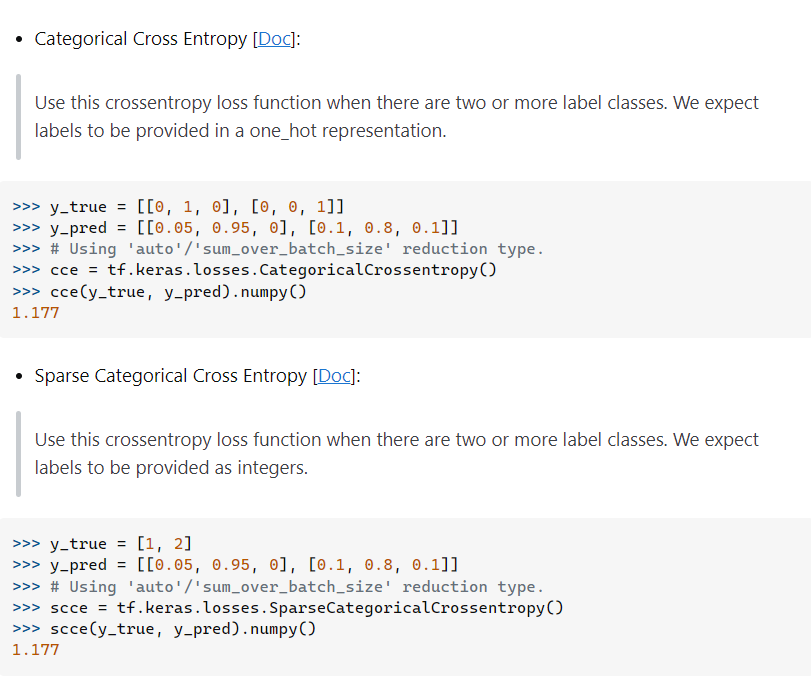

In [33]:
EPOCHS = 3

loss_fn1 = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True)
loss_fn2 = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)

losses = []
for epoch in range(EPOCHS):
    print("Starting epoch: %d"% epoch )
    for step, (x_batch_train, y_batch_train) in enumerate(train_tfdataset):
        with tf.GradientTape() as tape:
            answer_start_scores, answer_end_scores = model(x_batch_train)
            loss_start = loss_fn1(y_batch_train['start_positions'], answer_start_scores)
            loss_end = loss_fn2(y_batch_train['end_positions'], answer_end_scores)
            loss = 0.5 * (loss_start + loss_end)
        losses.append(loss)
        grads = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))
      
        train_accuracy_start = tf.keras.metrics.sparse_categorical_accuracy(y_batch_train['start_positions'], answer_start_scores)
        train_accuracy_end =  tf.keras.metrics.sparse_categorical_accuracy(y_batch_train['end_positions'], answer_end_scores) 
        # Khoảng từ 0 -> 1 connect giữa đoán đúng vị trí đầu và cuối
        train_accuracy = tf.reduce_mean((train_accuracy_start + train_accuracy_end) / 2.0)
        if step % 20 == 0:
            print("Training loss (for one batch) at step %d: %.4f"% (step, 
                                                                   float(loss_start)))
            print("Training accuracy (for one batch) at step %d: %.4f"% (step, train_accuracy))

Starting epoch: 0
Training loss (for one batch) at step 0: 7.9522
Training accuracy (for one batch) at step 0: 0.0000


KeyboardInterrupt: 

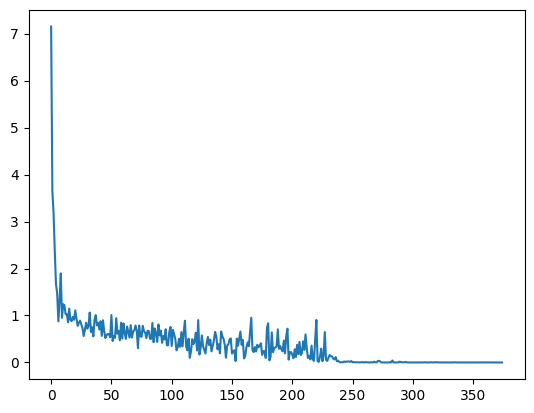

In [ ]:
from matplotlib.pyplot import plot

plot(losses)

In [ ]:
question, text = 'What is your name?','My name is Son. Her name is Linh.'
input_dict = tokenizer(text, question, return_tensors='tf')
outputs = model(input_dict)
start_logits = outputs[0]
end_logits = outputs[1]
print(start_logits.shape, end_logits.shape)
print(start_logits)
all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
print(len(all_tokens))
print(all_tokens)
print(tf.math.argmax(start_logits, 1)[0], ' ', tf.math.argmax(end_logits, 1)[0])
answer = ' '.join(all_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0]+1])
print(question, answer.capitalize())

(1, 19) (1, 19)
tf.Tensor(
[[-11.604739   -8.120051   -4.455324  -10.80796   -11.059621   -9.934911
   -4.543705   -7.9648046 -11.035044  -10.831549   -9.423824  -12.258655
  -11.18893   -10.150071  -11.919167  -10.597833  -12.103602  -13.276805
  -11.188958 ]], shape=(1, 19), dtype=float32)
19
['[CLS]', 'my', 'name', 'is', 'son', '.', 'her', 'name', 'is', 'lin', '##h', '.', '[SEP]', 'what', 'is', 'your', 'name', '?', '[SEP]']
tf.Tensor(2, shape=(), dtype=int64)   tf.Tensor(2, shape=(), dtype=int64)
What is your name? Name


In [103]:
from sklearn.metrics import f1_score, accuracy_score
def compute_metrics(pred):
    start_labels = pred.label_ids[0]
    start_preds = pred.predictions[0].argmax(-1)
    end_labels = pred.label_ids[1]
    end_preds = pred.predictions[1].argmax(-1)
    
    f1_start = f1_score(start_labels, start_preds, average='macro')
    f1_end = f1_score(end_labels, end_preds, average='macro')

    acc_start = accuracy_score(start_labels, start_preds)
    acc_end = accuracy_score(end_labels, end_preds)
    return {
        'f1_start': f1_start,
        'f1_end': f1_end,
        'accuracy_start': acc_start,
        'accuracy_end': acc_end
    }

In [126]:
pytorch_model = DistilBertForQuestionAnswering.from_pretrained("E:/Question Answering/model/pytorch/")

In [127]:
columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']
train_ds.set_format(type='pt', columns=columns_to_return)
test_ds.set_format(type='pt', columns=columns_to_return)

  2%|▏         | 49/2500 [00:17<01:51, 21.90it/s]

In [80]:
train_ds

Dataset({
    features: ['question', 'sentences', 'answer', 'str_idx', 'end_idx', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 1000
})

In [124]:
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter
writer = SummaryWriter('E:/Question Answering/QA/tb_logs')

training_args = TrainingArguments(
    output_dir='results',          
    overwrite_output_dir=True,
    num_train_epochs=1,              
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,   
    warmup_steps=20,                
    weight_decay=0.01,               
    logging_dir="E:/Question Answering/QA/tb_logs",            
    logging_steps=50,
)

trainer = Trainer(
    model=pytorch_model,                 
    args=training_args,                  
    train_dataset=train_ds,         
    eval_dataset=test_ds,
    compute_metrics=compute_metrics             
)

# Train the model and write loss to the TensorBoard
for epoch in range(10):
    trainer.train()
    loss = [log for log in trainer.state.log_history if 'loss' in log][-1]['loss']
    writer.add_scalar('Loss/train', loss, epoch)

# Don't forget to close the writer
writer.close()

 42%|████▏     | 52/125 [00:02<00:03, 21.56it/s] 

{'loss': 1.6807, 'grad_norm': 9.816168785095215, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.4}


 82%|████████▏ | 103/125 [00:05<00:01, 21.09it/s]

{'loss': 0.6713, 'grad_norm': 9.597490310668945, 'learning_rate': 1.1904761904761905e-05, 'epoch': 0.8}


100%|██████████| 125/125 [00:06<00:00, 20.46it/s]


{'train_runtime': 6.1086, 'train_samples_per_second': 163.704, 'train_steps_per_second': 20.463, 'train_loss': 1.0750540924072265, 'epoch': 1.0}


 43%|████▎     | 54/125 [00:02<00:03, 21.54it/s] 

{'loss': 0.6963, 'grad_norm': 16.491893768310547, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.4}


 82%|████████▏ | 102/125 [00:04<00:01, 21.02it/s]

{'loss': 0.4584, 'grad_norm': 15.90575885772705, 'learning_rate': 1.1904761904761905e-05, 'epoch': 0.8}


100%|██████████| 125/125 [00:05<00:00, 21.77it/s]


{'train_runtime': 5.7391, 'train_samples_per_second': 174.243, 'train_steps_per_second': 21.78, 'train_loss': 0.5548460845947265, 'epoch': 1.0}


 43%|████▎     | 54/125 [00:02<00:03, 20.41it/s] 

{'loss': 0.4809, 'grad_norm': 14.018754005432129, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.4}


 82%|████████▏ | 102/125 [00:04<00:01, 20.73it/s]

{'loss': 0.3222, 'grad_norm': 4.151683330535889, 'learning_rate': 1.1904761904761905e-05, 'epoch': 0.8}


100%|██████████| 125/125 [00:05<00:00, 21.47it/s]


{'train_runtime': 5.8175, 'train_samples_per_second': 171.894, 'train_steps_per_second': 21.487, 'train_loss': 0.37759871673583983, 'epoch': 1.0}


 43%|████▎     | 54/125 [00:02<00:03, 21.53it/s] 

{'loss': 0.2659, 'grad_norm': 14.456275939941406, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.4}


 82%|████████▏ | 102/125 [00:04<00:01, 20.82it/s]

{'loss': 0.1291, 'grad_norm': 0.4243188202381134, 'learning_rate': 1.1904761904761905e-05, 'epoch': 0.8}


100%|██████████| 125/125 [00:05<00:00, 21.86it/s]


{'train_runtime': 5.718, 'train_samples_per_second': 174.886, 'train_steps_per_second': 21.861, 'train_loss': 0.1724005699157715, 'epoch': 1.0}


 43%|████▎     | 54/125 [00:02<00:03, 21.49it/s] 

{'loss': 0.0514, 'grad_norm': 0.07474280148744583, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.4}


 82%|████████▏ | 102/125 [00:04<00:01, 21.49it/s]

{'loss': 0.0326, 'grad_norm': 0.0015759102534502745, 'learning_rate': 1.1904761904761905e-05, 'epoch': 0.8}


100%|██████████| 125/125 [00:05<00:00, 21.75it/s]


{'train_runtime': 5.7498, 'train_samples_per_second': 173.919, 'train_steps_per_second': 21.74, 'train_loss': 0.03501395463943482, 'epoch': 1.0}


 43%|████▎     | 54/125 [00:02<00:03, 21.45it/s] 

{'loss': 0.0532, 'grad_norm': 80.40203857421875, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.4}


 82%|████████▏ | 102/125 [00:04<00:01, 21.03it/s]

{'loss': 0.0536, 'grad_norm': 0.0007646073936484754, 'learning_rate': 1.1904761904761905e-05, 'epoch': 0.8}


100%|██████████| 125/125 [00:05<00:00, 21.57it/s]


{'train_runtime': 5.7751, 'train_samples_per_second': 173.158, 'train_steps_per_second': 21.645, 'train_loss': 0.04299908995628357, 'epoch': 1.0}


 43%|████▎     | 54/125 [00:02<00:03, 21.03it/s] 

{'loss': 0.0154, 'grad_norm': 0.014766404405236244, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.4}


 82%|████████▏ | 102/125 [00:04<00:01, 21.15it/s]

{'loss': 0.0295, 'grad_norm': 0.016222666949033737, 'learning_rate': 1.1904761904761905e-05, 'epoch': 0.8}


100%|██████████| 125/125 [00:05<00:00, 21.73it/s]


{'train_runtime': 5.744, 'train_samples_per_second': 174.093, 'train_steps_per_second': 21.762, 'train_loss': 0.018009325284510852, 'epoch': 1.0}


 43%|████▎     | 54/125 [00:02<00:03, 21.11it/s] 

{'loss': 0.013, 'grad_norm': 0.0012670664582401514, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.4}


 82%|████████▏ | 102/125 [00:04<00:01, 18.99it/s]

{'loss': 0.0124, 'grad_norm': 0.0015511197270825505, 'learning_rate': 1.1904761904761905e-05, 'epoch': 0.8}


100%|██████████| 125/125 [00:05<00:00, 21.56it/s]


{'train_runtime': 5.7905, 'train_samples_per_second': 172.697, 'train_steps_per_second': 21.587, 'train_loss': 0.010190825030207634, 'epoch': 1.0}


 43%|████▎     | 54/125 [00:02<00:03, 21.88it/s] 

{'loss': 0.0573, 'grad_norm': 0.006719245109707117, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.4}


 84%|████████▍ | 105/125 [00:04<00:00, 21.77it/s]

{'loss': 0.0283, 'grad_norm': 0.0007284619496203959, 'learning_rate': 1.1904761904761905e-05, 'epoch': 0.8}


100%|██████████| 125/125 [00:05<00:00, 21.89it/s]


{'train_runtime': 5.6994, 'train_samples_per_second': 175.458, 'train_steps_per_second': 21.932, 'train_loss': 0.034994877934455874, 'epoch': 1.0}


 43%|████▎     | 54/125 [00:02<00:03, 21.38it/s] 

{'loss': 0.0035, 'grad_norm': 0.04047146067023277, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.4}


 82%|████████▏ | 102/125 [00:04<00:01, 20.93it/s]

{'loss': 0.0015, 'grad_norm': 0.00036460935370996594, 'learning_rate': 1.1904761904761905e-05, 'epoch': 0.8}


100%|██████████| 125/125 [00:05<00:00, 21.81it/s]

{'train_runtime': 5.7332, 'train_samples_per_second': 174.422, 'train_steps_per_second': 21.803, 'train_loss': 0.006370832204818725, 'epoch': 1.0}


In [128]:

training_args = TrainingArguments(
    output_dir='results',          # output directory
    overwrite_output_dir=True,
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=20,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir="E:/Question Answering/QA/tb_logs",            # directory for storing logs
    logging_steps=50,
)

trainer = Trainer(
    model=pytorch_model,                 # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_ds,         # training dataset
    eval_dataset=test_ds,
    compute_metrics=compute_metrics             # evaluation dataset
)

trainer.train()

 81%|████████  | 101/125 [06:05<01:26,  3.62s/it]

  2%|▏         | 49/2500 [00:22<01:51, 21.90it/s]

{'loss': 1.6502, 'grad_norm': 6.058170795440674, 'learning_rate': 4.939516129032259e-05, 'epoch': 0.4}



  2%|▏         | 49/2500 [00:24<01:51, 21.90it/s]

{'loss': 0.7729, 'grad_norm': 4.153200149536133, 'learning_rate': 4.8387096774193554e-05, 'epoch': 0.8}



  2%|▏         | 49/2500 [00:27<01:51, 21.90it/s] 

{'loss': 0.6742, 'grad_norm': 9.911105155944824, 'learning_rate': 4.737903225806452e-05, 'epoch': 1.2}



  2%|▏         | 49/2500 [00:29<01:51, 21.90it/s] 

{'loss': 0.6137, 'grad_norm': 118.36365509033203, 'learning_rate': 4.637096774193548e-05, 'epoch': 1.6}



  2%|▏         | 49/2500 [00:31<01:51, 21.90it/s] 

{'loss': 0.424, 'grad_norm': 19.05754852294922, 'learning_rate': 4.5362903225806455e-05, 'epoch': 2.0}



  2%|▏         | 49/2500 [00:33<01:51, 21.90it/s] 

{'loss': 0.3748, 'grad_norm': 3.9264936447143555, 'learning_rate': 4.435483870967742e-05, 'epoch': 2.4}



  2%|▏         | 49/2500 [00:36<01:51, 21.90it/s] 


{'loss': 0.1683, 'grad_norm': 0.18162815272808075, 'learning_rate': 4.334677419354839e-05, 'epoch': 2.8}


  2%|▏         | 49/2500 [00:38<01:51, 21.90it/s] 

{'loss': 0.0974, 'grad_norm': 0.13605321943759918, 'learning_rate': 4.2338709677419356e-05, 'epoch': 3.2}



  2%|▏         | 49/2500 [00:40<01:51, 21.90it/s] 

{'loss': 0.0763, 'grad_norm': 0.022437799721956253, 'learning_rate': 4.133064516129033e-05, 'epoch': 3.6}



  2%|▏         | 49/2500 [00:43<01:51, 21.90it/s] Checkpoint destination directory results\checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.0528, 'grad_norm': 0.0511326789855957, 'learning_rate': 4.032258064516129e-05, 'epoch': 4.0}



  2%|▏         | 49/2500 [00:46<01:51, 21.90it/s] 

{'loss': 0.0021, 'grad_norm': 0.03871135413646698, 'learning_rate': 3.931451612903226e-05, 'epoch': 4.4}



  2%|▏         | 49/2500 [00:48<01:51, 21.90it/s] 

{'loss': 0.0281, 'grad_norm': 3.233992099761963, 'learning_rate': 3.8306451612903224e-05, 'epoch': 4.8}



  2%|▏         | 49/2500 [00:50<01:51, 21.90it/s] 


{'loss': 0.018, 'grad_norm': 0.22361379861831665, 'learning_rate': 3.72983870967742e-05, 'epoch': 5.2}


  2%|▏         | 49/2500 [00:53<01:51, 21.90it/s] 


{'loss': 0.0316, 'grad_norm': 0.0028693396598100662, 'learning_rate': 3.6290322580645165e-05, 'epoch': 5.6}


  2%|▏         | 49/2500 [00:55<01:51, 21.90it/s] 

{'loss': 0.0123, 'grad_norm': 0.00028128098347224295, 'learning_rate': 3.528225806451613e-05, 'epoch': 6.0}



  2%|▏         | 49/2500 [00:57<01:51, 21.90it/s] 

{'loss': 0.0147, 'grad_norm': 0.0032579111866652966, 'learning_rate': 3.427419354838709e-05, 'epoch': 6.4}



  2%|▏         | 49/2500 [00:59<01:51, 21.90it/s] 

{'loss': 0.0275, 'grad_norm': 0.0025696689262986183, 'learning_rate': 3.3266129032258067e-05, 'epoch': 6.8}



  2%|▏         | 49/2500 [01:02<01:51, 21.90it/s] 

{'loss': 0.0001, 'grad_norm': 0.00036728085251525044, 'learning_rate': 3.2258064516129034e-05, 'epoch': 7.2}



  2%|▏         | 49/2500 [01:04<01:51, 21.90it/s] 

{'loss': 0.0119, 'grad_norm': 0.009970670565962791, 'learning_rate': 3.125e-05, 'epoch': 7.6}



  2%|▏         | 49/2500 [01:06<01:51, 21.90it/s] Checkpoint destination directory results\checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.0196, 'grad_norm': 0.0007952252053655684, 'learning_rate': 3.024193548387097e-05, 'epoch': 8.0}



  2%|▏         | 49/2500 [01:09<01:51, 21.90it/s]  

{'loss': 0.0393, 'grad_norm': 0.0025467376690357924, 'learning_rate': 2.9233870967741938e-05, 'epoch': 8.4}



  2%|▏         | 49/2500 [01:12<01:51, 21.90it/s]  

{'loss': 0.0001, 'grad_norm': 0.00027780316304415464, 'learning_rate': 2.822580645161291e-05, 'epoch': 8.8}



  2%|▏         | 49/2500 [01:14<01:51, 21.90it/s]  

{'loss': 0.0001, 'grad_norm': 0.00044197842362336814, 'learning_rate': 2.721774193548387e-05, 'epoch': 9.2}



  2%|▏         | 49/2500 [01:16<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 0.0006331098265945911, 'learning_rate': 2.620967741935484e-05, 'epoch': 9.6}



  2%|▏         | 49/2500 [01:19<01:51, 21.90it/s]  

{'loss': 0.0365, 'grad_norm': 0.0001315676054218784, 'learning_rate': 2.5201612903225806e-05, 'epoch': 10.0}



  2%|▏         | 49/2500 [01:21<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 0.004013970494270325, 'learning_rate': 2.4193548387096777e-05, 'epoch': 10.4}



  2%|▏         | 49/2500 [01:23<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 0.026733221486210823, 'learning_rate': 2.318548387096774e-05, 'epoch': 10.8}



  2%|▏         | 49/2500 [01:25<01:51, 21.90it/s]  

{'loss': 0.0003, 'grad_norm': 0.00014522195851895958, 'learning_rate': 2.217741935483871e-05, 'epoch': 11.2}



  2%|▏         | 49/2500 [01:28<01:51, 21.90it/s]  

{'loss': 0.0018, 'grad_norm': 81.61238098144531, 'learning_rate': 2.1169354838709678e-05, 'epoch': 11.6}



  2%|▏         | 49/2500 [01:30<01:51, 21.90it/s]  Checkpoint destination directory results\checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.0, 'grad_norm': 0.022311076521873474, 'learning_rate': 2.0161290322580645e-05, 'epoch': 12.0}



  2%|▏         | 49/2500 [01:33<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 0.0005521687562577426, 'learning_rate': 1.9153225806451612e-05, 'epoch': 12.4}



  2%|▏         | 49/2500 [01:35<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 0.0016699850093573332, 'learning_rate': 1.8145161290322583e-05, 'epoch': 12.8}



  2%|▏         | 49/2500 [01:38<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 0.00048458355013281107, 'learning_rate': 1.7137096774193546e-05, 'epoch': 13.2}



  2%|▏         | 49/2500 [01:40<01:51, 21.90it/s]  

{'loss': 0.0261, 'grad_norm': 0.00018537002324592322, 'learning_rate': 1.6129032258064517e-05, 'epoch': 13.6}



  2%|▏         | 49/2500 [01:42<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 1.931329461513087e-05, 'learning_rate': 1.5120967741935486e-05, 'epoch': 14.0}



  2%|▏         | 49/2500 [01:45<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 7.30494866729714e-05, 'learning_rate': 1.4112903225806454e-05, 'epoch': 14.4}



  2%|▏         | 49/2500 [01:47<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 0.0001450016425224021, 'learning_rate': 1.310483870967742e-05, 'epoch': 14.8}



  2%|▏         | 49/2500 [01:49<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 4.375377102405764e-06, 'learning_rate': 1.2096774193548388e-05, 'epoch': 15.2}



  2%|▏         | 49/2500 [01:51<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 0.0003901567542925477, 'learning_rate': 1.1088709677419356e-05, 'epoch': 15.6}



  2%|▏         | 49/2500 [01:54<01:51, 21.90it/s]  Checkpoint destination directory results\checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.0, 'grad_norm': 5.567675907514058e-05, 'learning_rate': 1.0080645161290323e-05, 'epoch': 16.0}



  2%|▏         | 49/2500 [01:57<01:51, 21.90it/s]  


{'loss': 0.0, 'grad_norm': 2.558498272264842e-05, 'learning_rate': 9.072580645161291e-06, 'epoch': 16.4}


  2%|▏         | 49/2500 [01:59<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 0.00027817286900244653, 'learning_rate': 8.064516129032258e-06, 'epoch': 16.8}



  2%|▏         | 49/2500 [02:02<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 1.7993943401961587e-05, 'learning_rate': 7.056451612903227e-06, 'epoch': 17.2}



  2%|▏         | 49/2500 [02:04<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 8.86560810613446e-05, 'learning_rate': 6.048387096774194e-06, 'epoch': 17.6}



  2%|▏         | 49/2500 [02:07<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 4.182533302810043e-05, 'learning_rate': 5.040322580645161e-06, 'epoch': 18.0}



  2%|▏         | 49/2500 [02:09<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 0.004428461659699678, 'learning_rate': 4.032258064516129e-06, 'epoch': 18.4}



  2%|▏         | 49/2500 [02:11<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 2.5491092401352944e-06, 'learning_rate': 3.024193548387097e-06, 'epoch': 18.8}



  2%|▏         | 49/2500 [02:14<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 0.00010060335625894368, 'learning_rate': 2.0161290322580646e-06, 'epoch': 19.2}



  2%|▏         | 49/2500 [02:16<01:51, 21.90it/s]  

{'loss': 0.0, 'grad_norm': 5.4986481700325385e-05, 'learning_rate': 1.0080645161290323e-06, 'epoch': 19.6}



  2%|▏         | 49/2500 [02:18<01:51, 21.90it/s]  Checkpoint destination directory results\checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.0, 'grad_norm': 0.028264660388231277, 'learning_rate': 0.0, 'epoch': 20.0}



100%|██████████| 2500/2500 [01:59<00:00, 20.93it/s]

{'train_runtime': 119.4574, 'train_samples_per_second': 167.424, 'train_steps_per_second': 20.928, 'train_loss': 0.1035015743244323, 'epoch': 20.0}


TrainOutput(global_step=2500, training_loss=0.1035015743244323, metrics={'train_runtime': 119.4574, 'train_samples_per_second': 167.424, 'train_steps_per_second': 20.928, 'train_loss': 0.1035015743244323, 'epoch': 20.0})

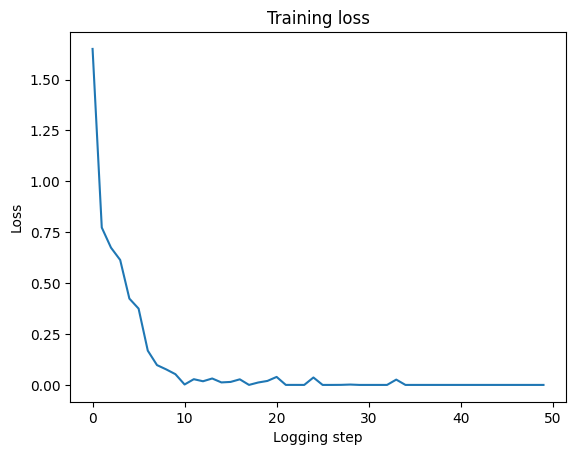

In [129]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
loss_values = [entry['loss'] for entry in log_history if 'loss' in entry]

# Plot the training loss
plt.plot(loss_values)
plt.title('Training loss')
plt.xlabel('Logging step')
plt.ylabel('Loss')
plt.show()

In [130]:
trainer.evaluate(test_ds)

100%|██████████| 125/125 [00:01<00:00, 81.09it/s]


{'eval_loss': 6.115422479524568e-07,
 'eval_f1_start': 1.0,
 'eval_f1_end': 1.0,
 'eval_accuracy_start': 1.0,
 'eval_accuracy_end': 1.0,
 'eval_runtime': 1.6849,
 'eval_samples_per_second': 593.515,
 'eval_steps_per_second': 74.189,
 'epoch': 20.0}

In [83]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

pytorch_model.to(device)

question, text = 'What is east of the hallway?','The kitchen is east of the hallway. The garden is south of the bedroom.'

input_dict = tokenizer(text, question, return_tensors='pt')

input_ids = input_dict['input_ids'].to(device)
attention_mask = input_dict['attention_mask'].to(device)

outputs = pytorch_model(input_ids, attention_mask=attention_mask)

start_logits = outputs[0]
end_logits = outputs[1]

all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer = ' '.join(all_tokens[torch.argmax(start_logits, 1)[0] : torch.argmax(end_logits, 1)[0]+1])

print(question, answer.capitalize())

What is east of the hallway? Kitchen


In [ ]:
import torch
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cuda', index=0)

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF
